In [27]:
import os
# This can make the kernel die if it doesn't go well
os.environ['R_HOME'] = "C:\Program Files\R\R-4.1.0"
from rpy2.robjects.packages import importr
r_utils = importr('utils')

In [28]:
# r_utils.install_packages('coda')

In [29]:
r_coda = importr('coda')

In [30]:
import pandas as pd

import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

In [31]:
pd.set_option('display.max_colwidth', -1)

C:\Users\zkirsan\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [32]:
import nltk
#nltk.download('stopwords')

In [33]:
import re
from matplotlib import gridspec
import math
from sklearn.metrics import accuracy_score

### Part 1: Elon Musk's Tweets

In the first part of this project, we will be working with text from the @elonmusk Twitter account. This consists of all tweets from the account from 1/6/2020 to 1/6/2021. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted from Elon Musk.


In [34]:
df_tweets_orig = pd.read_csv('data/tweets_data.csv')

In [35]:
df_tweets = df_tweets_orig.copy()

In [36]:
df_tweets.head(10)

,date,text,tokenized_text,like_count,quote_count,reply_count,retweet_count
0,2020-06-19,{Juneteenth is henceforth considered a US holiday at Tesla &amp; SpaceX},"['juneteenth', 'henceforth', 'considered', 'holiday', 'tesla', 'spacex']",402800,2590,5884,31264
1,2020-06-21,"{2019 seems so quaint &amp; long ago https://t.co/xfdfcbr0DS, That is our purpose, Tesla Bioweapon Defense Mode\nhttps://t.co/48s5D3ZQO0, We must pass The Great Filter, Mars is my souldog, If heat death is the end of the universe, it really is all about the journey, RT @cleantechnica: Exclusive Pro Photos: Tesla Cybertruck At The Petersen Auto Museum https://t.co/3ixBOsRTst, RT @Tesla: https://t.co/26o1bAP14v}","['seems', 'quaint', 'long', 'ago', 'purpose', 'tesla', 'bioweapon', 'defense', 'mode', 'must', 'pass', 'great', 'filter', 'mars', 'souldog', 'heat', 'death', 'end', 'universe', 'really', 'journey', 'cleantechnica', 'exclusive', 'pro', 'photos', 'tesla', 'cybertruck', 'petersen', 'auto', 'museum', 'tesla']",735629,4879,17989,57388
2,2020-06-22,"{Tentative date for Tesla Shareholder Meeting &amp; Battery Day is Sept 15. Will include tour of cell production system., Reminder that Tesla Full Self-Driving (FSD) price goes up by $1k on July 1st, Enabling basic Tesla Autopilot via Tesla in-app purchase is reduced to $2k until July 1}","['tentative', 'date', 'tesla', 'shareholder', 'meeting', 'battery', 'day', 'sept', 'include', 'tour', 'cell', 'production', 'system', 'reminder', 'tesla', 'full', 'self', 'driving', 'fsd', 'price', 'goes', 'july', 'enabling', 'basic', 'tesla', 'autopilot', 'tesla', 'app', 'purchase', 'reduced', 'july']",133516,892,5246,5438
3,2020-06-25,"{RT @GerberKawasaki: First thoughts driving my new Tesla model Y. Review and discussion of what I learned at Tesla today and outlook for the…, Two Starship tanks in the midbay https://t.co/QJ2V882WOC, Special thanks to Tesla trucking &amp; rail partners for figuratively &amp; literally going the extra mile, Apologies to Tesla customers for shifting delivery dates. It’s a crazy world out there!, RT @cleantechnica: Wall Street Journal: Tesla Model Y Offers “Fierce, Velvety” Driving Characteristics https://t.co/dGY24gCVLz}","['gerberkawasaki', 'first', 'thoughts', 'driving', 'new', 'tesla', 'model', 'review', 'discussion', 'learned', 'tesla', 'today', 'outlook', 'two', 'starship', 'tanks', 'midbay', 'special', 'thanks', 'tesla', 'trucking', 'rail', 'partners', 'figuratively', 'literally', 'going', 'extra', 'mile', 'apologies', 'tesla', 'customers', 'shifting', 'delivery', 'dates', 'crazy', 'world', 'cleantechnica', 'wall', 'street', 'journal', 'tesla', 'model', 'offers', 'fierce', 'velvety', 'driving', 'characteristics']",259296,1039,4758,10802
4,2020-06-26,"{.@JeffBezos is a copy 🐈 haha https://t.co/plR7uupqBG, Who controls the memes,\ncontrols the Universe, https://t.co/e9dPKVSjjl, Literally, Only a matter of time before someone steals a Tesla while playing GTA on a Tesla, North American Supercharger usage tracking to exceed pre covid highs in 2 to 3 weeks. Lot of noise out there. This is signal. https://t.co/PCC5DlthtA}","['jeffbezos', 'copy', 'controls', 'memes', 'controls', 'universe', 'literally', 'matter', 'time', 'someone', 'steals', 'tesla', 'playing', 'gta', 'tesla', 'north', 'american', 'supercharger', 'usage', 'tracking', 'exceed', 'pre', 'covid', 'highs', 'weeks', 'lot', 'noise', 'signal']",2248367,24436,32923,300062
5,2020-06-28,"{Btw, Tesla actually receives *least* subsidies of any automaker in US. Federal tax credit applies to other automaker EVs, but no longer Tesla., Great Model Y review by @jayleno https://t.co/DzsZ7eugWp, RT @_TomCross_: Cybertruck inside Petersen Automotive Museum.\n#tesla #Cybertruck https://t.co/2XaZoM40Ve, 69 days after 4/20 again haha}","['tesla', 'receives', 'least', 'subsidies', 'automaker', 'federal', 'tax', 'credit', 'applies', 'automaker', 'evs', 'longer', 'tesla', 'great', 'model', 'review', 'jayleno', 'tomcross_', 'cybertruck', 'inside', 'petersen

In [37]:
df_tweets.dtypes 

date              object
text              object
tokenized_text    object
like_count        int64 
quote_count       int64 
reply_count       int64 
retweet_count     int64 
dtype: object

In [38]:
df_tweets.shape

(284, 7)

In [39]:
df_tweets['preprocessed_text'] = df_tweets.text.str.lower()

In [40]:
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]

['from',
 'yours',
 'doesn',
 "needn't",
 "mightn't",
 "don't",
 'do',
 'hers',
 'which',
 'for']

In [41]:
df_tweets.preprocessed_text = df_tweets.preprocessed_text.apply(lambda row: ' '.join([word for word in row.split() if word not in (en_stop_words)]))

In [42]:
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')

In [43]:
df_tweets['tokenized_text'] = df_tweets.preprocessed_text.apply(lambda row: tokenizer.tokenize(row))

In [44]:
df_tweets.head(1)

,date,text,tokenized_text,like_count,quote_count,reply_count,retweet_count,preprocessed_text
0,2020-06-19,{Juneteenth is henceforth considered a US holiday at Tesla &amp; SpaceX},"[juneteenth, henceforth, considered, us, holiday, tesla, amp, spacex]",402800,2590,5884,31264,{juneteenth henceforth considered us holiday tesla &amp; spacex}


In [45]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [46]:
get_most_freq_words([ word for tweet in df_tweets.tokenized_text for word in tweet],10)

[('https', 400),
 ('co', 394),
 ('rt', 213),
 ('spacex', 175),
 ('tesla', 116),
 ('amp', 107),
 ('launch', 57),
 ('dragon', 56),
 ('falcon', 53),
 ('first', 44)]

In [50]:
## the function below takes the original tweets dataframe, the column containing the tweet text, the dictionary of stop words
## it return a clean dataframe and a list of nb most frequent words, or all if None

def clean_tweets(df=df_tweets_orig, 
                 tweet_col='text', 
                 date_col='date',
                 stop_words=en_stop_words,
                 nb=None):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    # calculate word frequencies
    word_freqs = get_most_freq_words([ word for tweet in df_copy['tokenized_' + tweet_col] for word in tweet],nb)
    
    return word_freqs, df_copy

In [56]:
extended_stop_words = en_stop_words | \
                      {
                          'amp', 'rt', 'th','co', 're', 've', 'kim', 'daca', 'us', 'it', 'th', 'you', 'haha', 'st', 'et',
                          'so', 'iii', 'also', 've', 'la', 're', 'the', 'https', 'wow', 'actually', 'due', 'ft', 'pcr', 'via',
                          'am', 'gt', 'com', 'since', 'in', 'me', 'and', 'btw', 'yesterday', 'ii', 'inu', 'on', 'http', 'to', 
                          'vs', 'rd', 'ur', 'of', 'bs', 'km', 'est', 'em', 'lz', 'kms', 'aft', 'nd',  'here’s', 're',
                          'mqxfakpzf' 'mph', 'ht', 'etc', 'dm'
                      }

In [57]:
most_frequent_words, df_tweets_clean = clean_tweets(stop_words=extended_stop_words, nb=None)

In [61]:
most_frequent_words[:15]

[('spacex', 175),
 ('tesla', 116),
 ('amp', 107),
 ('rt', 66),
 ('launch', 57),
 ('dragon', 56),
 ('falcon', 53),
 ('first', 44),
 ('crew', 37),
 ('nasa', 36),
 ('model', 30),
 ('space_station', 30),
 ('mission', 27),
 ('starship', 26),
 ('earth', 25)]

In [60]:
df_tweets_clean.head()

,date,text,tokenized_text,like_count,quote_count,reply_count,retweet_count,preprocessed_text
0,2020-06-19,{Juneteenth is henceforth considered a US holiday at Tesla &amp; SpaceX},"[juneteenth, henceforth, considered, holiday, tesla, amp, spacex]",402800,2590,5884,31264,{juneteenth henceforth considered holiday tesla &amp; spacex}
1,2020-06-21,"{2019 seems so quaint &amp; long ago https://t.co/xfdfcbr0DS, That is our purpose, Tesla Bioweapon Defense Mode\nhttps://t.co/48s5D3ZQO0, We must pass The Great Filter, Mars is my souldog, If heat death is the end of the universe, it really is all about the journey, RT @cleantechnica: Exclusive Pro Photos: Tesla Cybertruck At The Petersen Auto Museum https://t.co/3ixBOsRTst, RT @Tesla: https://t.co/26o1bAP14v}","[seems, quaint, amp, long, ago, purpose, tesla, bioweapon, defense, mode, must, pass, great, filter, mars, souldog, heat, death, end, universe, really, journey, cleantechnica, exclusive, pro, photos, tesla, cybertruck, petersen, auto, museum, tesla]",735629,4879,17989,57388,"{2019 seems quaint &amp; long ago purpose, tesla bioweapon defense mode must pass great filter, mars souldog, heat death end universe, really journey, @cleantechnica: exclusive pro photos: tesla cybertruck petersen auto museum @tesla:"
2,2020-06-22,"{Tentative date for Tesla Shareholder Meeting &amp; Battery Day is Sept 15. Will include tour of cell production system., Reminder that Tesla Full Self-Driving (FSD) price goes up by $1k on July 1st, Enabling basic Tesla Autopilot via Tesla in-app purchase is reduced to $2k until July 1}","[tentative, date, tesla, shareholder, meeting, amp, battery, day, sept, include, tour, cell, production, system, reminder, tesla, full, self, driving, fsd, price, goes, july, st, enabling, basic, tesla, autopilot, tesla, in, app, purchase, reduced, july]",133516,892,5246,5438,"{tentative date tesla shareholder meeting &amp; battery day sept 15. include tour cell production system., reminder tesla full self-driving (fsd) price goes $1k july 1st, enabling basic tesla autopilot tesla in-app purchase reduced $2k july 1}"
3,2020-06-25,"{RT @GerberKawasaki: First thoughts driving my new Tesla model Y. Review and discussion of what I learned at Tesla today and outlook for the…, Two Starship tanks in the midbay https://t.co/QJ2V882WOC, Special thanks to Tesla trucking &amp; rail partners for figuratively &amp; literally going the extra mile, Apologies to Tesla customers for shifting delivery dates. It’s a crazy world out there!, RT @cleantechnica: Wall Street Journal: Tesla Model Y Offers “Fierce, Velvety” Driving Characteristics https://t.co/dGY24gCVLz}","[rt, gerberkawasaki, first, thoughts, driving, new, tesla, model, review, discussion, learned, tesla, today, outlook, the, two, starship, tanks, midbay, special, thanks, tesla, trucking, amp, rail, partners, figuratively, amp, literally, going, extra, mile, apologies, tesla, customers, shifting, delivery, dates, it, crazy, world, there, cleantechnica, wall, street, journal, tesla, model, offers, fierce, velvety, driving, characteristics]",259296,1039,4758,10802,"{rt @gerberkawasaki: first thoughts driving new tesla model y. review discussion learned tesla today outlook the…, two starship tanks midbay special thanks tesla trucking &amp; rail partners figuratively &amp; literally going extra mile, apologies tesla customers shifting delivery dates. it’s crazy world there!, @cleantechnica: wall street journal: tesla model offers “fierce, velvety” driving characteristics"
4,2020-06-26,"{.@JeffBezos is a copy 🐈 haha https://t.co/plR7uupqBG, Who controls the memes,\ncontrols the Universe, https://t.co/e9dPKVSjjl, Literally, Only a matter of time before someone steals a Tesla while playing GTA on a Tesla, North American Supercharger usage tracking to exceed pre covid highs in 2 to 3 weeks. Lot of noise out there. This is signal. https://t.co/PCC5DlthtA}","[jeffbezos, copy, controls, memes, controls, universe, literally, matter, time, someone,

Latent Dirichlet Allocation is the probabilistic transformation of a bag-of-words count into a lower-dimensional topic space. Tweets are viewed as a subject distribution. The distribution of all the terms in the vocabulary, in turn, represents topics. However, we don't know how many subjects are in the corpus or how many tweets each topic contains. With LDA, we wish to approach the topic assignment of tweets as a random variable that is estimated from the available data.

In [62]:
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

In [63]:
print("We have {} tweets and {} words in the dictionary.".format(df_tweets_clean.shape[0],len(tweets_dictionary)))

We have 284 tweets and 2360 words in the dictionary.


In [64]:
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

It's an art to find the correct number of themes for LDA. Perplexity techniques are frequently preferred over Topic Coherence procedures. With coherence, we measure the degree of semantic similarity between a topic's high-scoring words to determine its coherence. As a result, more human-interpretable subjects emerge. The method chooses the most commonly used words in each topic. To determine the coherence score for a given topic, it computes and aggregates the pairwise scores (UMass) for each of the words.

In [65]:
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
    print(nb_topics,coh)

1 -3.657772565934098
2 -5.726576925690322
3 -5.510263643342096
4 -6.190757022550146
5 -8.367654149710336
6 -6.965542531256051
7 -8.317941422789776
8 -7.492406778264419
9 -8.557450855693906
10 -8.9893567491431
11 -8.473136395856418
12 -9.637453438437817
13 -9.505346135098412
14 -10.14016296750367
15 -8.693490206440577
16 -10.48886912695739
17 -10.041755482778244
18 -10.397058361412942
19 -8.460325012329607
20 -9.536900681754704
21 -9.313491456046783
22 -9.501543854897589
23 -9.360525803776026
24 -9.248277698142413
25 -9.663034690979199
26 -9.867291150239408
27 -9.670174640637086
28 -9.796277556977762
29 -9.515239867236462
30 -10.004067640424747
31 -8.774761635406554
32 -9.991075278197592
33 -9.55648014284012
34 -10.132678928292608
35 -9.081673371050913


We visualize the average coherence score per topic for a range of models trained with a different number of topics below. The number of topics for which the average score plateaus, is the sweet spot we are looking for. So our best guess for the number of topics is around 22. We should consider that, typically a corpus with very short documents (tweets in our case) tends to be more difficult to apply to coherent models than a corpus with longer documents.

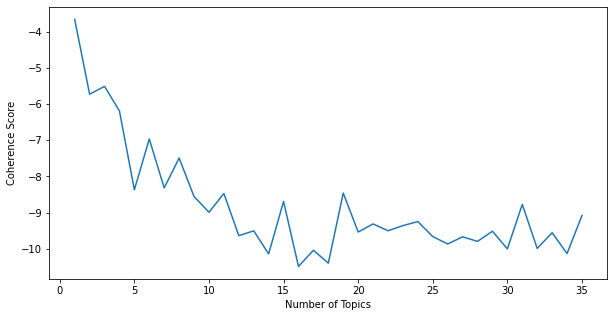

In [66]:
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

**Run LDA on the texts using the optimal value of $k$ found via the analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility.**

In [67]:
k = 22
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

In [68]:
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

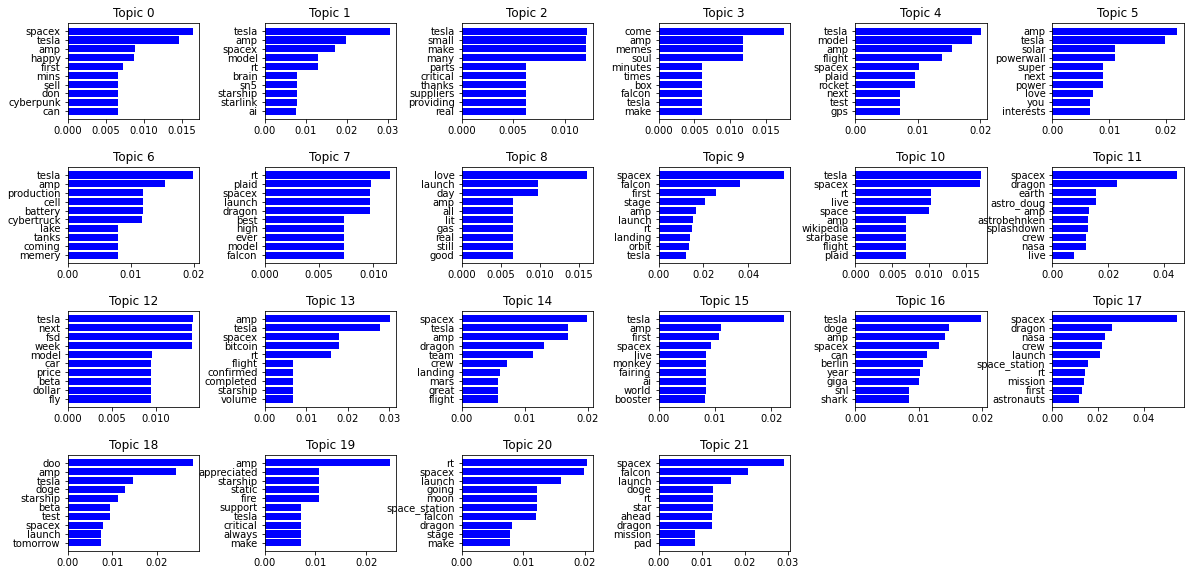

In [69]:
plot_top_words()

The topics do not make totally sense. However we can see the following meaningful match:

Topic 1 - bitcoin

Topic 2, - tesla

etc